In [1]:
import os
import sys
import pathlib
import yaml
import numpy
import pandas
import xarray
import h5netcdf
from datetime import datetime
from datetime import date
from glob import glob
import time
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
file_locations = pathlib.Path(
    '/scratch/rmueller/MIDOSS/Results/MOHID_results_locations_try3_10042022_18:58:46.yaml'
)

In [3]:
with file_locations.open("rt") as f:
    run_paths = yaml.safe_load(f)


In [4]:
input_file = run_paths['all'][0]

In [5]:
# open NETCDF
with xarray.open_dataset(input_file, engine='h5netcdf') as ds:
    spill_start = ds.time[0]
    spill_end = ds.time[-1]
    # Select surface volume, concentration and dissolution
    vol3d=ds.OilWaterColumnOilVol_3D.isel({'grid_z': 39})
    conc3d=ds.OilConcentration_3D.isel({'grid_z': 39})
beach_threshold = 5e-3
BeachVolume=ds.Beaching_Volume.where(
        ds.Beaching_Volume>beach_threshold
    ) 

# open Lagrangian.dat
input_dir=os.path.dirname(os.path.abspath(input_file))
# identify oil type and run number from .nc file to query Lagrangian.dat file
nrun = input_file.split('/')[-1].split('-')[-1][:-3]
oil_tag = input_file.split('/')[-1].split('_')[1].split('-')[0]
Lagrangian_file = input_dir+f'/Lagrangian_{oil_tag}-{nrun}.dat'
 #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Grab spill information from Lagrangian file
with open(Lagrangian_file, 'r') as lagrangianFile:
    print(Lagrangian_file)
    for line in lagrangianFile:
        if 'POINT_VOLUME              :' in line: 
            # select spill volume quantity after ':'
            spillvolume = line.split(':')[-1].split('\n')[0]
        if 'POSITION_COORDINATES       :' in line:
            spill_location = line.split(':')[-1].split('\n')[0]
            print(spill_location)
        if 'POSITION_COORDINATES      :' in line:
            spill_location = line.split(':')[-1].split('\n')[0]
            print(spill_location)

/scratch/dlatorne/MIDOSS/runs/monte-carlo/1-200_near-BP_try3_2022-03-25T132341/results/1-200_near-BP_try3-0/Lagrangian_bunker-0.dat
 -122.7687378 48.85820007


In [6]:
spill_location.split(' ')

['', '-122.7687378', '48.85820007']

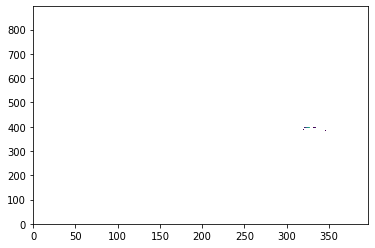

In [7]:
plt.pcolormesh(BeachVolume)

In [8]:
regions = ['SOG','cwchn','lummi']
cwchn = numpy.full(BeachVolume.shape, False)
cwchn[340:500,150:295] = True

# # Lummi
lummi = numpy.full(BeachVolume.shape, False)
lummi[375:410,300:340] = True

# Strait of Georgia
SOG = numpy.full(BeachVolume.shape, False)
SOG[335:715,100:396] = True

masks = {}
for region in regions:
    masks[region] = numpy.ma.masked_array(globals()[region])

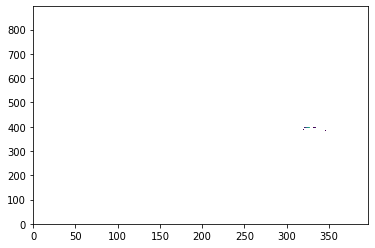

In [9]:
BV = numpy.asarray(BeachVolume)
#BV[masks['SOG']]=0
plt.pcolormesh(BV)

In [10]:
numpy.nansum(BV[masks['lummi']])

1408.8994191728607

In [11]:
numpy.nansum(BV[masks['cwchn']])

0.0

In [12]:
numpy.nansum(BV[masks['SOG']])

1427.3339233034833

In [13]:
numpy.nansum(numpy.asarray(BeachVolume)[masks['SOG']]) 

1427.3339233034833

In [14]:
numpy.nansum(BeachVolume)

1427.3339233034833

In [15]:
regions

['SOG', 'cwchn', 'lummi']

In [16]:
out={}
for region in regions:
    out[region]={}
    out[region]['lat'] = []
    out[region]['lon'] = []
    out[region]['vol']=[]
for region in regions:        
    volByRegion=numpy.nansum(numpy.asarray(BeachVolume)[masks[region]]) 
    print(volByRegion)
    if volByRegion > 0:
        print(region)
        out[region]['lat'].append(spill_location.split(' ')[2])
        out[region]['lon'].append(spill_location.split(' ')[1])
        out[region]['vol'].append(spillvolume)

1427.3339233034833
SOG
0.0
1408.8994191728607
lummi


In [17]:
len(run_paths['all'])

6995

## loop through all files and and find spill locations that affect region

In [18]:
regions

['SOG', 'cwchn', 'lummi']

In [19]:
%%time
nruns = len(run_paths['all'])
run_list = run_paths['all']
beach_threshold = 5e-3
out={}
for region in regions:
    out[region]={}
    out[region]['lat'] = []
    out[region]['lon'] = []
    out[region]['vol']=[]
for run in range(nruns):
    print(f'Run {run} of {nruns}')
    input_file=run_list[run]
    input_dir=os.path.dirname(os.path.abspath(input_file))
    # identify oil type and run number from .nc file to query Lagrangian.dat file
    nrun = input_file.split('/')[-1].split('-')[-1][:-3]
    oil_tag = input_file.split('/')[-1].split('_')[1].split('-')[0]
    Lagrangian_file = input_dir+f'/Lagrangian_{oil_tag}-{nrun}.dat'
    if os.path.isfile(input_file):
        # Read in results from output netcdf
        try:
            with xarray.open_dataset(input_file, engine='h5netcdf') as ds:
                spill_start = ds.time[0]
                spill_end = ds.time[-1]
                # Select surface volume, concentration and dissolution
                vol3d=ds.OilWaterColumnOilVol_3D.isel({'grid_z': 39})
                conc3d=ds.OilConcentration_3D.isel({'grid_z': 39})

        except:
            print(f'missing {input_file}') 
            continue 
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # Grab spill information from Lagrangian file
        with open(Lagrangian_file, 'r') as lagrangianFile:
            
            for line in lagrangianFile:
                if 'POINT_VOLUME              :' in line: 
                    # select spill volume quantity after ':'
                    spillvolume = line.split(':')[-1].split('\n')[0]
                if 'POSITION_COORDINATES       :' in line:
                    spill_location = line.split(':')[-1].split('\n')[0]
                if 'POSITION_COORDINATES      :' in line:
                    spill_location = line.split(':')[-1].split('\n')[0]
                   
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # Store basics: Filename, lat, lon, spill volume
        #files.append(input_file)
        spill_volume=float(spillvolume)
        latitude=(float(spill_location.split(' ')[2]))
        longitude=(float(spill_location.split(' ')[1]))
        # ~~~~~~~~~~~~~~

        # Beaching 
        # ~~~~~~~~~~~~~~    
        # Save volume over threshold 
        BeachVolume=ds.Beaching_Volume.where(
            ds.Beaching_Volume>beach_threshold
        )
        
        for region in regions:
            volByRegion=numpy.nansum(numpy.asarray(BeachVolume)[masks[region]])           
            if volByRegion > 0:               
                out[region]['lat'].append(latitude)
                out[region]['lon'].append(longitude)
                out[region]['vol'].append(float(spillvolume))
df={}
out_dir = pathlib.Path('/scratch/rmueller/MIDOSS/Results/')
for region in regions:
    out_f = out_dir/f'{region}_SpillLocations.yaml'
    with open(out_f, "w") as out_file:
        yaml.safe_dump(out[region], out_file)

Run 0 of 6995
Run 1 of 6995
Run 2 of 6995
Run 3 of 6995
Run 4 of 6995
Run 5 of 6995
Run 6 of 6995
Run 7 of 6995
Run 8 of 6995
Run 9 of 6995
Run 10 of 6995
Run 11 of 6995
Run 12 of 6995
Run 13 of 6995
Run 14 of 6995
Run 15 of 6995
Run 16 of 6995
Run 17 of 6995
Run 18 of 6995
Run 19 of 6995
Run 20 of 6995
Run 21 of 6995
Run 22 of 6995
Run 23 of 6995
Run 24 of 6995
Run 25 of 6995
Run 26 of 6995
Run 27 of 6995
Run 28 of 6995
Run 29 of 6995
Run 30 of 6995
Run 31 of 6995
Run 32 of 6995
Run 33 of 6995
Run 34 of 6995
Run 35 of 6995
Run 36 of 6995
Run 37 of 6995
Run 38 of 6995
Run 39 of 6995
Run 40 of 6995
Run 41 of 6995
Run 42 of 6995
Run 43 of 6995
Run 44 of 6995
Run 45 of 6995
Run 46 of 6995
Run 47 of 6995
Run 48 of 6995
Run 49 of 6995
Run 50 of 6995
Run 51 of 6995
Run 52 of 6995
Run 53 of 6995
Run 54 of 6995
Run 55 of 6995
Run 56 of 6995
Run 57 of 6995
Run 58 of 6995
Run 59 of 6995
Run 60 of 6995
Run 61 of 6995
Run 62 of 6995
Run 63 of 6995
Run 64 of 6995
Run 65 of 6995
Run 66 of 6995
Run 6